# Visualize embeddings (t-SNE / UMAP / PCA)
Load saved embeddings, sample for plotting, run t-SNE and UMAP (if available), save PNGs and show inline.


In [1]:
import os
os.chdir(r"C:\BDA_CEP_Part-2")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

try:
    import umap
    have_umap = True
except Exception:
    have_umap = False

EMB_DIR = "outputs/embeddings"
OUT_DIR = "outputs/figures"
os.makedirs(OUT_DIR, exist_ok=True)

# Plotting options
N_PLOT = 500         # max points per source to plot
TSNE_PERPLEX = 30
TSNE_ITER = 1000
RANDOM_STATE = 42
FIGSIZE = (6,6)


In [2]:
real_emb_path = os.path.join(EMB_DIR, "real_emb.npy")
synth_emb_path = os.path.join(EMB_DIR, "synth_emb.npy")
assert os.path.exists(real_emb_path), f"Missing {real_emb_path}"
assert os.path.exists(synth_emb_path), f"Missing {synth_emb_path}"

real_emb = np.load(real_emb_path)
synth_emb = np.load(synth_emb_path)
print("Loaded embeddings:", real_emb.shape, synth_emb.shape)


Loaded embeddings: (216, 64) (2000, 64)


In [3]:
rng = np.random.default_rng(RANDOM_STATE)

n_plot = min(N_PLOT, real_emb.shape[0], synth_emb.shape[0])
r_idx = rng.permutation(real_emb.shape[0])[:n_plot]
s_idx = rng.permutation(synth_emb.shape[0])[:n_plot]

X = np.vstack([real_emb[r_idx], synth_emb[s_idx]])
labels = np.array([0]*n_plot + [1]*n_plot)   # 0 = real, 1 = synth

print("Plotting sample size per class:", n_plot)


Plotting sample size per class: 216


In [4]:
def scatter_and_save(Z, labels, title, fname, figsize=FIGSIZE):
    plt.figure(figsize=figsize)
    plt.scatter(Z[labels==0,0], Z[labels==0,1], s=8, label='real', alpha=0.7)
    plt.scatter(Z[labels==1,0], Z[labels==1,1], s=8, label='synth', alpha=0.7)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=200, bbox_inches='tight')
    plt.show()

def compute_silhouette(Z, labels):
    try:
        return float(silhouette_score(Z, labels))
    except Exception:
        return None


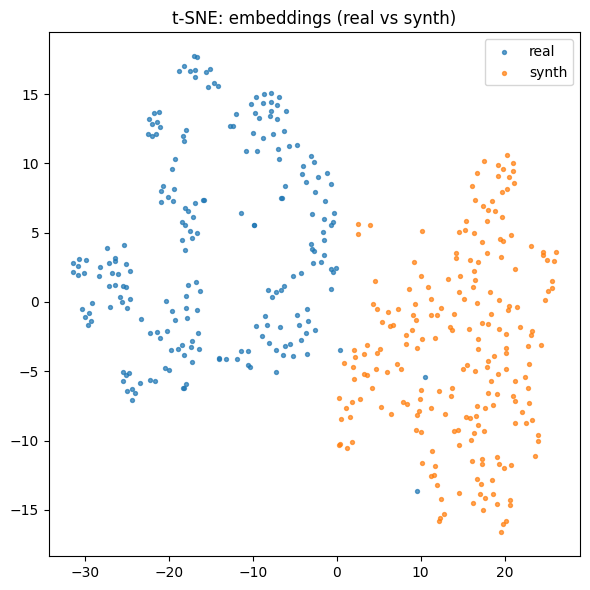

t-SNE silhouette score: 0.5566787123680115


In [5]:
ts = TSNE(n_components=2, perplexity=TSNE_PERPLEX, max_iter=TSNE_ITER, random_state=RANDOM_STATE, init='pca')
Z_tsne = ts.fit_transform(X)
tsne_png = os.path.join(OUT_DIR, "tsne_emb_real_vs_synth.png")
scatter_and_save(Z_tsne, labels, "t-SNE: embeddings (real vs synth)", tsne_png)
sil_tsne = compute_silhouette(Z_tsne, labels)
print("t-SNE silhouette score:", sil_tsne)


c:\BDA_CEP_Part-2\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


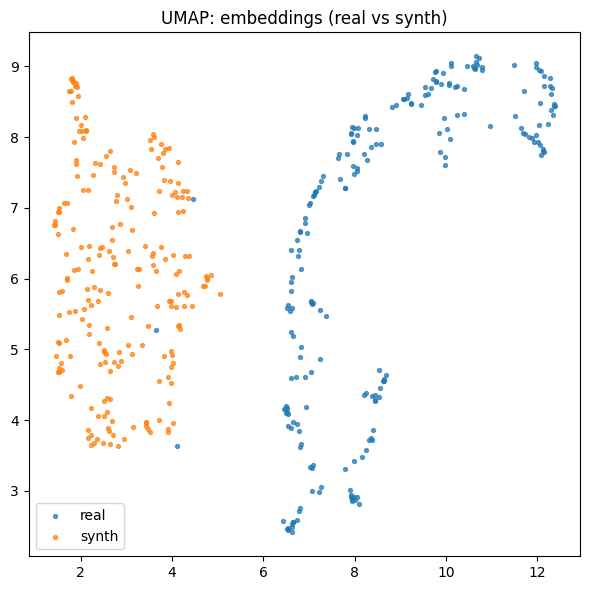

UMAP silhouette score: 0.5262996554374695


In [6]:
if have_umap:
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=RANDOM_STATE)
    Z_umap = reducer.fit_transform(X)
    umap_png = os.path.join(OUT_DIR, "umap_emb_real_vs_synth.png")
    scatter_and_save(Z_umap, labels, "UMAP: embeddings (real vs synth)", umap_png)
    sil_umap = compute_silhouette(Z_umap, labels)
    print("UMAP silhouette score:", sil_umap)
else:
    print("UMAP not installed; using PCA as fallback for coarse visualization.")
    Z_pca = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X)
    pca_png = os.path.join(OUT_DIR, "pca_emb_real_vs_synth.png")
    scatter_and_save(Z_pca, labels, "PCA: embeddings (real vs synth)", pca_png)
    sil_pca = compute_silhouette(Z_pca, labels)
    print("PCA silhouette score:", sil_pca)


## Quick numeric diagnostics
Silhouette scores are printed above — they provide a single-number sense of how separable real vs synth are in the projected space.


In [7]:
meta_out = os.path.join(OUT_DIR, "emb_plot_sample_coords.npz")
np.savez(meta_out,
         r_idx=r_idx, s_idx=s_idx,
         Z_tsne=Z_tsne,
         labels=labels)
print("Saved sampled coords & indices to:", meta_out)


Saved sampled coords & indices to: outputs/figures\emb_plot_sample_coords.npz
